<a href="https://colab.research.google.com/github/enum123/Image_Classification_Using_CNN_on_Cifar10_data/blob/main/Image_Classification_on_Cifar10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [7]:
# Importing TensorFlow and Keras libraries for deep learning
import tensorflow as tf
from tensorflow.keras.datasets import cifar10  # Loading the CIFAR-10 dataset for image classification
from tensorflow.keras.models import Sequential  # Building models by stacking layers sequentially
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # Core layers for building CNNs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  # Callbacks for training optimization
from tensorflow.keras.regularizers import l2  # Regularization to prevent overfitting
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Performing data augmentation
from tensorflow.keras.layers import Input  # Defining input layer structure
from tensorflow.keras.optimizers import Adamax  # Optimizer for training the model
from sklearn.model_selection import train_test_split

# Libraries for data visualization and mathematical operations
import matplotlib.pyplot as plt  # Visualizing data and model performance
import numpy as np  # Performing numerical computations and handling arrays


# Getting DataSet

In [8]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

# Performing Data Augmentation

In [9]:
# Data augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=15,          # Randomly rotate images within a range of 15 degrees
    width_shift_range=0.1,      # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1,     # Randomly shift images vertically by up to 10% of the height
    horizontal_flip=True,       # Randomly flip images horizontally
    zoom_range=0.1              # Randomly zoom in or out by up to 10%
)

# Fit the data generator on the training data to compute statistics like mean and std
datagen.fit(x_train)

# Data augmentation for the validation set (minimal augmentation is usually recommended)
val_datagen = ImageDataGenerator(
    rotation_range=10,          # Rotate images within a smaller range (10 degrees)
    width_shift_range=0.05,     # Slight horizontal shift (5%)
    height_shift_range=0.05,    # Slight vertical shift (5%)
    horizontal_flip=True        # Enable horizontal flipping for slight variations
)

# Fit the data generator on the validation data
val_datagen.fit(x_val)

# Example: To generate augmented images for training, use datagen.flow()
train_generator = datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

# Print message to confirm
print("Data augmentation applied to training and validation sets.")


Data augmentation applied to training and validation sets.


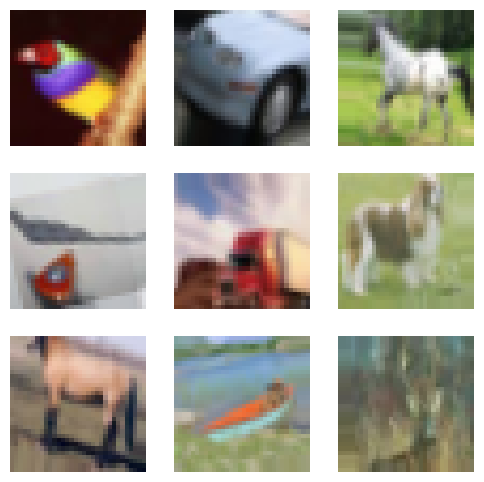

In [10]:
# Display a 3x3 grid of augmented images
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):  # Generate a batch of 9 images
    plt.figure(figsize=(6, 6))  # Set figure size
    for i in range(9):  # Loop through the 9 images in the batch
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
        plt.imshow(x_batch[i])  # Display the image
        plt.axis('off')  # Hide axes for better visualization
    plt.show()
    break  # Display one batch and exit the loop


# Defining The Model Structure

In [11]:
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10, kernel_regularizer_val=0.01, dropout_rate=0.25, dense_dropout_rate=0.5):
    model = Sequential([
        Input(shape=input_shape),

        # Block 1: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Block 2: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Block 3: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Block 4: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
        Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Block 5: 2 Conv2D layers (10th Conv2D added here) + BatchNormalization + MaxPooling + Dropout
        Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        Dropout(dense_dropout_rate),
        Dense(num_classes, activation='softmax')  # Output layer for `num_classes` classes
    ])
    return model

model = create_cnn_model(input_shape=(32, 32, 3), num_classes=10, kernel_regularizer_val=0.01, dropout_rate=0.3, dense_dropout_rate=0.5)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,151,402 (19.65 MB)

 Trainable params: 5,145,898 (19.63 MB)

 Non-trainable params: 5,504 (21.50 KB)

# Compliling the Model

In [12]:
# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the Model

In [13]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)                          # Reduce learning rate
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),  # Training data with augmentation
    epochs=50,
    validation_data=(x_test, y_test),              # Validation data
    callbacks=callbacks                            # Add callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 60ms/step - accuracy: 0.2000 - loss: 25.6784 - val_accuracy: 0.2493 - val_loss: 15.7315 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.3686 - loss: 13.0716 - val_accuracy: 0.3650 - val_loss: 7.5858 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.4491 - loss: 6.3280 - val_accuracy: 0.4654 - val_loss: 3.8003 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.5050 - loss: 3.4057 - val_accuracy: 0.4695 - val_loss: 2.7443 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.5548 - loss: 2.3654 - val_accuracy: 0.4114 - val_loss: 3.1309 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.5909 - loss: 2.0023 - val_accuracy: 0.5842 - val_loss: 1.8904 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.6114 - loss: 1.8

# Training Curves

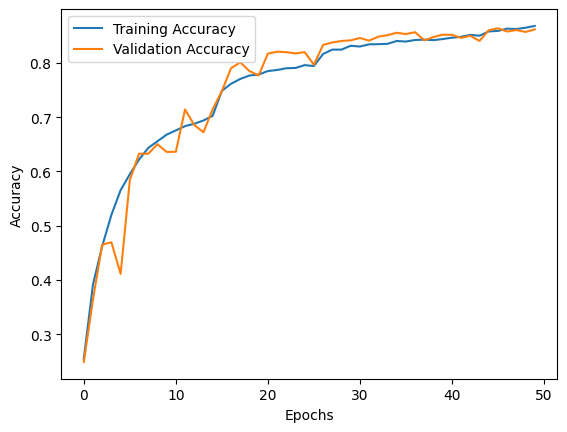

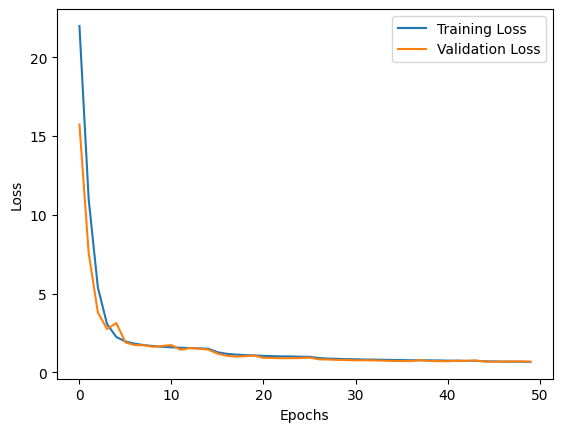

In [14]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
